<img src="../../img/logo_white_bkg_small.png" align="left" /> 
# Feature Engineering
This worksheet covers concepts covered in the first part of day 2 - Feature Engineering.  It should take no more than 30-40 minutes to complete.  Please raise your hand if you get stuck.  

## Import the Libraries
For this exercise, we will be using:
* Pandas (http://pandas.pydata.org/pandas-docs/stable/)
* Numpy (https://docs.scipy.org/doc/numpy/reference/)
* Matplotlib (http://matplotlib.org/api/pyplot_api.html)
* Scikit-learn (http://scikit-learn.org/stable/documentation.html)
* YellowBrick (http://www.scikit-yb.org/en/latest/)
* Seaborn (https://seaborn.pydata.org)

In [1]:
# Load Libraries - Make sure to run this cell!
import pandas as pd
import numpy as np
import re
from collections import Counter
from sklearn import feature_extraction, tree, model_selection, metrics
from yellowbrick.features import Rank2D
from yellowbrick.features import RadViz
from yellowbrick.features import ParallelCoordinates
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

## Feature Engineering

This worksheet is a step-by-step guide on how to detect domains that were generated using "Domain Generation Algorithm" (DGA). We will walk you through the process of transforming raw domain strings to Machine Learning features and creating a decision tree classifer which you will use to determine whether a given domain is legit or not. Once you have implemented the classifier, the worksheet will walk you through evaluating your model.  

Overview 2 main steps:

1. **Feature Engineering** - from raw domain strings to numeric Machine Learning features using DataFrame manipulations
2. **Machine Learning Classification** - predict whether a domain is legit or not using a Decision Tree Classifier


  

**DGA - Background**

"Various families of malware use domain generation
algorithms (DGAs) to generate a large number of pseudo-random
domain names to connect to a command and control (C2) server.
In order to block DGA C2 traffic, security organizations must
first discover the algorithm by reverse engineering malware
samples, then generate a list of domains for a given seed. The
domains are then either preregistered, sink-holed or published
in a DNS blacklist. This process is not only tedious, but can
be readily circumvented by malware authors. An alternative
approach to stop malware from using DGAs is to intercept DNS
queries on a network and predict whether domains are DGA
generated. Much of the previous work in DGA detection is based
on finding groupings of like domains and using their statistical
properties to determine if they are DGA generated. However,
these techniques are run over large time windows and cannot be
used for real-time detection and prevention. In addition, many of
these techniques also use contextual information such as passive
DNS and aggregations of all NXDomains throughout a network.
Such requirements are not only costly to integrate, they may not
be possible due to real-world constraints of many systems (such
as endpoint detection). An alternative to these systems is a much
harder problem: detect DGA generation on a per domain basis
with no information except for the domain name. Previous work
to solve this harder problem exhibits poor performance and many
of these systems rely heavily on manual creation of features;
a time consuming process that can easily be circumvented by
malware authors..."    
[Citation: Woodbridge et. al 2016: "Predicting Domain Generation Algorithms with Long Short-Term Memory Networks"]

A better alternative for real-world deployment would be to use "featureless deep learning" - We have a separate notebook where you can see how this can be implemented!( https://www.endgame.com/blog/technical-blog/using-deep-learning-detect-dgas, https://github.com/endgameinc/dga_predict)

**However, let's learn the basics first!!!**


## Worksheet for Part 1 - Feature Engineering

In [3]:
## Load data
df = pd.read_csv('../../data/dga_data_small.csv')
df.drop(['host', 'subclass'], axis=1, inplace=True)
print(df.shape)
df.sample(n=5).head() # print a random sample of the DataFrame

(2000, 2)


,isDGA,domain
1332,legit,col3negoriginal
1137,legit,chronicle
87,dga,tocvgewjqdukj
546,dga,1jrksb1pr70zrkdspxqreszpj
919,dga,eqrbbusxbmlgfpy


In [4]:
df[df.isDGA == 'legit'].head()

,isDGA,domain
1000,legit,empressr
1001,legit,noticiasvenezuela
1002,legit,iptorrents
1003,legit,parspal
1004,legit,onlineschooladmissions


In [12]:
# Google's 10000 most common english words will be needed to derive a feature called ngrams...
# therefore we already load them here.
top_en_words = pd.read_csv('../../data/google-10000-english.txt', header=None, names=['words'])
top_en_words.sample(n=5).head()
# Source: https://github.com/first20hours/google-10000-english
d = top_en_words

## Part 1 - Feature Engineering

Option 1 to derive Machine Learning features is to manually hand-craft useful contextual information of the domain string. An alternative approach (not covered in this notebook) is "Featureless Deep Learning", where an embedding layer takes care of deriving features - a huge step towards more "AI".

Previous academic research has focused on the following features that are based on contextual information:

**List of features**:

1. Length ["length"]
2. Number of digits ["digits"]
3. Entropy ["entropy"] - use ```H_entropy``` function provided 
4. Vowel to consonant ratio ["vowel-cons"] - use ```vowel_consonant_ratio``` function provided
5. N-grams ["n-grams"] - use ```ngram``` functions provided

**Tasks**:    
Split into A and B parts, see below...


Please run the following function cell and then continue reading the next markdown cell with more details on how to derive those features. Have fun!



In [13]:
def H_entropy (x):
    # Calculate Shannon Entropy
    prob = [ float(x.count(c)) / len(x) for c in dict.fromkeys(list(x)) ] 
    H = - sum([ p * np.log2(p) for p in prob ]) 
    return H

def vowel_consonant_ratio (x):
    # Calculate vowel to consonant ratio
    x = x.lower()
    vowels_pattern = re.compile('([aeiou])')
    consonants_pattern = re.compile('([b-df-hj-np-tv-z])')
    vowels = re.findall(vowels_pattern, x)
    consonants = re.findall(consonants_pattern, x)
    try:
        ratio = len(vowels) / len(consonants)
    except: # catch zero devision exception 
        ratio = 0  
    return ratio

### Tasks - A - Feature Engineering

Please try to derive a new pandas 2D DataFrame with a new column for each of feature. Focus on ```length```, ```digits```, ```entropy``` and ```vowel-cons``` here. Also make sure to encode the ```isDGA``` column as integers. [pandas.Series.str](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.str.html), [pandas.Series.replace](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.replace.html) and [pandas.Series,apply](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.apply.html) can be very helpful to quickly derive those features. Functions you need to apply here are provided in above cell.

The ```ngram``` is a bit more complicated, see next instruction cell to add this feature...


In [14]:
# derive features
df['length'] = df.domain.str.len()
df['digits'] = df.domain.str.count('[0-9]')
df['entropy'] = df.domain.apply(H_entropy)
df['vowel-cons'] = df.domain.apply(vowel_consonant_ratio)

# encode strings of target variable as integers
df.isDGA = df.isDGA.replace(to_replace = 'dga', value=1)
df.isDGA = df.isDGA.replace(to_replace = 'legit', value=0)
print(df.isDGA.value_counts())

# check intermediate 2D pandas DataFrame
df.sample(n=5).head()


1    1000
0    1000
Name: isDGA, dtype: int64


,isDGA,domain,length,digits,entropy,vowel-cons
496,1,3b1976d97c9f07fc4e7b3070b3740fc4,32,21,3.373778,0.100000
765,1,qcqtzdpreugmjflzpjvovzxpj,25,0,3.913270,0.136364
1632,0,xapo,4,0,2.000000,1.000000
86,1,nkigtpiytcvsd,13,0,3.392747,0.181818
1362,0,crackle,7,0,2.521641,0.400000


### Tasks - B - Feature Engineering

Finally, let's tackle the **ngram** feature. There are multiple steps involved to derive this feature. Here in this notebook, we use an implementation outlined in the this academic paper [Schiavoni 2014: "Phoenix: DGA-based Botnet Tracking and Intelligence" - see section: Linguistic Features](http://s2lab.isg.rhul.ac.uk/papers/files/dimva2014.pdf).


- **What are ngrams???** Imagine a string like 'facebook', if I were to derive all n-grams for n=2 (aka bi-grams) I would get '['fa', 'ac', 'ce', 'eb', 'bo', 'oo', 'ok']', so you see that you slide with one step from the left and just group 2 characters together each time, a tri-gram for 'facebook' would yielfd '['fac', 'ace', 'ceb', 'ebo', 'boo', 'ook']'. Ngrams have a long history in natural language processing, but are also used a lot for example in detecting malicious executable (raw byte ngrams in this case).

Steps involved:

1. We have the 10000 most common english words (see data file we loaded, we call this DataFrame ```top_en_words``` in this notebook). Now we run the ```ngrams``` functions on a list of all these words. The output here is a list that contains ALL 1-grams, bi-grams and tri-grams of these 10000 most common english words.
2. We use the ```Counter``` function from collections to derive a dictionary ```d``` that contains the counts of all unique 1-grams, bi-grams and tri-grams.
3. Our ```ngram_feature``` function will do the core magic. It takes your domain as input, splits it into ngrams (n is a function parameter) and then looks up these ngrams in the english dictionary ```d``` we derived in step 2. Function returns the normalized sum of all ngrams that were contained in the english dictionary. For example, running ```ngram_feature('facebook', d, 2)``` will return 171.28 (this value is just like the one published in the Schiavoni paper).
4. Finally ```average_ngram_feature``` wraps around ```ngram_feature```. You will use this function as your task is to derive a feature that gives the average of the ngram_feature for n=1,2 and 3. Input to this function should be a simple list with entries calling ```ngram_feature``` with n=1,2 and 3, hence a list of 3 ngram_feature results.   
5. **YOUR TURN: Apply ```average_ngram_feature``` to you domain column in the DataFrame thereby adding ```ngram``` to the df.**
6. **YOUR TURN: Finally drop the ```domain``` column from your DataFrame**.


Please run the following function cell and then write your code in the following cell.


In [17]:
# For simplicity let's just copy the needed function in here again
# Load dictionary of common english words from part 1
from six.moves import cPickle as pickle
with open('../../data/d_common_en_words' + '.pickle', 'rb') as f:
        d = pickle.load(f)

def H_entropy (x):
    # Calculate Shannon Entropy
    prob = [ float(x.count(c)) / len(x) for c in dict.fromkeys(list(x)) ] 
    H = - sum([ p * np.log2(p) for p in prob ]) 
    return H

def vowel_consonant_ratio (x):
    # Calculate vowel to consonant ratio
    x = x.lower()
    vowels_pattern = re.compile('([aeiou])')
    consonants_pattern = re.compile('([b-df-hj-np-tv-z])')
    vowels = re.findall(vowels_pattern, x)
    consonants = re.findall(consonants_pattern, x)
    try:
        ratio = len(vowels) / len(consonants)
    except: # catch zero devision exception 
        ratio = 0  
    return ratio

# ngrams: Implementation according to Schiavoni 2014: "Phoenix: DGA-based Botnet Tracking and Intelligence"
# http://s2lab.isg.rhul.ac.uk/papers/files/dimva2014.pdf

def ngrams(word, n):
    # Extract all ngrams and return a regular Python list
    # Input word: can be a simple string or a list of strings
    # Input n: Can be one integer or a list of integers 
    # if you want to extract multipe ngrams and have them all in one list
    
    l_ngrams = []
    if isinstance(word, list):
        for w in word:
            if isinstance(n, list):
                for curr_n in n:
                    ngrams = [w[i:i+curr_n] for i in range(0,len(w)-curr_n+1)]
                    l_ngrams.extend(ngrams)
            else:
                ngrams = [w[i:i+n] for i in range(0,len(w)-n+1)]
                l_ngrams.extend(ngrams)
    else:
        if isinstance(n, list):
            for curr_n in n:
                ngrams = [word[i:i+curr_n] for i in range(0,len(word)-curr_n+1)]
                l_ngrams.extend(ngrams)
        else:
            ngrams = [word[i:i+n] for i in range(0,len(word)-n+1)]
            l_ngrams.extend(ngrams)
#     print(l_ngrams)
    return l_ngrams

def ngram_feature(domain, d, n):
    # Input is your domain string or list of domain strings
    # a dictionary object d that contains the count for most common english words
    # finally you n either as int list or simple int defining the ngram length
    
    # Core magic: Looks up domain ngrams in english dictionary ngrams and sums up the 
    # respective english dictionary counts for the respective domain ngram
    # sum is normalized
    
    l_ngrams = ngrams(domain, n)
#     print(l_ngrams)
    count_sum=0
    for ngram in l_ngrams:
        if d[ngram]:
            count_sum+=d[ngram]
    try:
        feature = count_sum/(len(domain)-n+1)
    except:
        feature = 0
    return feature
    
def average_ngram_feature(l_ngram_feature):
    # input is a list of calls to ngram_feature(domain, d, n)
    # usually you would use various n values, like 1,2,3...
    return sum(l_ngram_feature)/len(l_ngram_feature)

In [19]:
df['ngrams'] = df.domain.apply(lambda x: average_ngram_feature([ngram_feature(x, d, 1), 
                                                                ngram_feature(x, d, 2), 
                                                                ngram_feature(x, d, 3)]))

# check final 2D pandas DataFrame containing all final features and the target vector isDGA
df.sample(10)

,isDGA,domain,length,digits,entropy,vowel-cons,ngrams
1886,0,mrcnetwork,10,0,3.121928,0.250000,1304.548148
51,1,69250cd4723eda09988f0066731ce10e,32,23,3.753928,0.800000,431.519198
1997,0,agava,5,0,1.370951,1.500000,1288.161111
1654,0,shoppydoo,9,0,2.419382,0.500000,1037.050265
453,1,25c7c2c6d30e7ebdca84278f5056dd95,32,19,3.702820,0.300000,470.959453
1512,0,digicafe,8,0,2.750000,1.000000,1422.420635
832,1,qkkxgedemxhrkw,14,0,3.182006,0.166667,777.976801
1280,0,loremipsum,10,0,3.121928,0.666667,1388.759259
1744,0,lyonnaise-des-eaux,18,0,3.461320,1.000000,1430.304466
270,1,ujmvnkosjtglab,14,0,3.664498,0.272727,878.954212


In [20]:
df_final = df
df_final = df_final.drop(['domain'], axis=1)
df_final.to_csv('../../data/dga_features_final_df.csv', index=False)
df_final.head()


,isDGA,length,digits,entropy,vowel-cons,ngrams
0,1,13,0,3.546594,0.300000,968.076729
1,1,25,10,3.833270,0.250000,480.946111
2,1,12,0,2.855389,0.090909,1036.337879
3,1,26,6,3.844107,0.052632,708.290256
4,1,12,0,3.084963,0.090909,897.515657


#### Breakpoint: Load Features and Labels

If you got stuck in Part 1, please simply load the feature matrix we prepared for you, so you can move on to Part 2 and train a Decision Tree Classifier.

In [23]:
df_final = pd.read_csv('../../data/our_data_dga_features_final_df.csv')
print(df_final.isDGA.value_counts())
df_final.sample(5)

1    1000
0    1000
Name: isDGA, dtype: int64


,isDGA,length,digits,entropy,vowel-cons,ngrams
551,1,20,0,3.384184,0.111111,650.662865
1813,0,6,0,2.251629,0.500000,1369.505556
1050,0,14,0,3.093069,0.555556,1601.336691
1324,0,8,0,2.500000,1.000000,1472.787698
1957,0,14,0,2.692381,1.000000,1820.185897


### Visualizing the Results
At this point, we've created a dataset which has many features that can be used for classification.  Using YellowBrick, your final step is to visualize the features to see which will be of value and which will not. 

First, let's create a Rank2D visualizer to compute the correlations between all the features.  Detailed documentation available here: http://www.scikit-yb.org/en/latest/examples/methods.html#feature-analysis

In [24]:
feature_names = ['length','digits','entropy','vowel-cons','ngrams']
features = df_final[feature_names]
target = df_final.isDGA

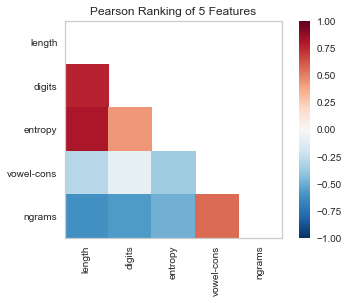

In [25]:
visualizer = Rank2D(algorithm='pearson',features=feature_names)
visualizer.fit_transform( features )
visualizer.poof()

Now let's use a Seaborn pairplot as well.  This will really show you which features have clear dividing lines between the classes.  Docs are available here: http://seaborn.pydata.org/generated/seaborn.pairplot.html

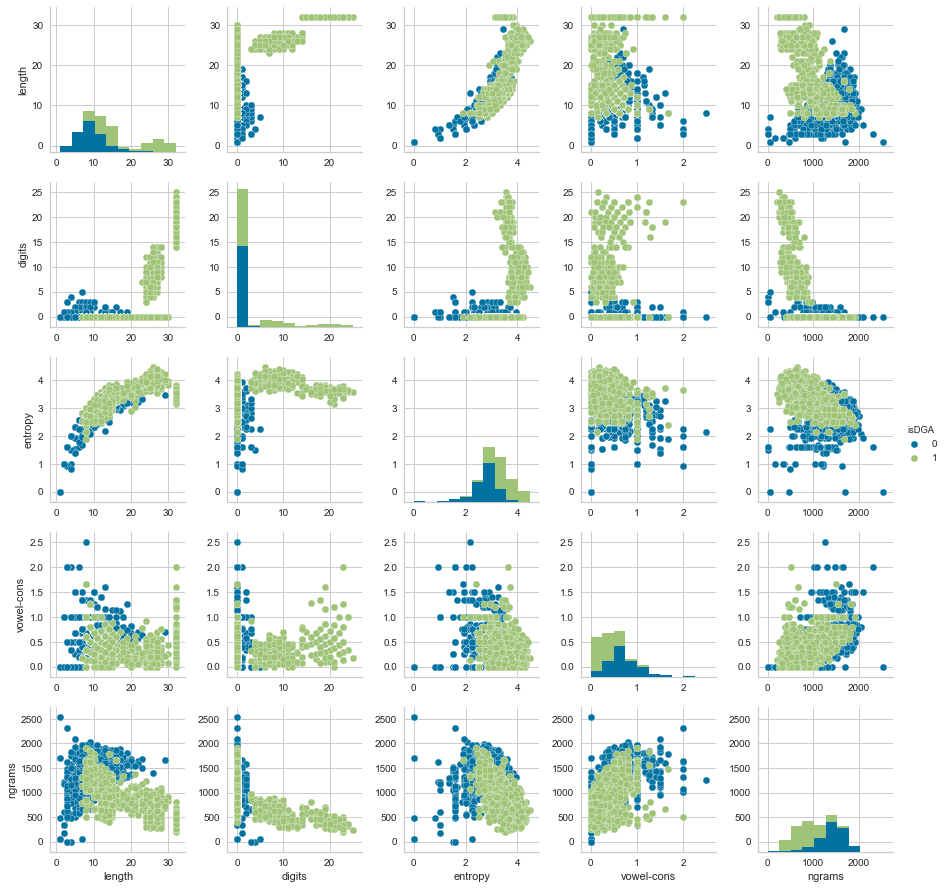

In [26]:
sns.pairplot(df_final, hue='isDGA', vars=feature_names)

Finally, let's try making a RadViz of the features.  This visualization will help us see whether there is too much noise to make accurate classifications. 

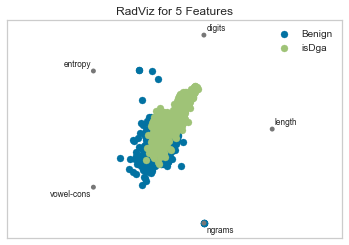

In [27]:
X = df_final[feature_names].as_matrix()
y = df_final.isDGA.as_matrix()

radvizualizer = RadViz(classes=['Benign','isDga'], features=feature_names)
radvizualizer.fit_transform( X, y)
radvizualizer.poof()

## Congrats!
Congrats!  You've now extracted features from the dataset and are ready to begin creating some supervised models!